<a href="https://colab.research.google.com/github/mmonch/Sidecar_Project/blob/main/notebooks/Sidecar_Project_Dictionary_approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id='Q0'></a>
<center><a target="_blank" href="https://sit.academy/"><img src="https://drive.google.com/uc?id=1z0U84GYqhbWWpCenFajh8_8XFRGyOc3U" width="200" style="background:none; border:none; box-shadow:none;" /></a> </center>
<center> <h1> Dictionary model </h1> </center>
<p style="margin-bottom:1cm;"></p>
<center><h4>Dae-Jin Rhee, SIT Academy, 2022</h4></center>
<p style="margin-bottom:1cm;"></p>

<div style="background:#EEEDF5;border-top:0.1cm solid #EF475B;border-bottom:0.1cm solid #EF475B;">
    <div style="margin-left: 0.5cm;margin-top: 0.5cm;margin-bottom: 0.5cm;color:#303030">
        <p><strong>Goal:</strong> Create a match-up dictionary for the generation of Business names.</p>
        <strong> Outline:</strong>
        <a id='P0' name="P0"></a>
        <ol>
            <li> <a style="color:#303030" href='#I'>Setup </a> </li>
            <li> <a style="color:#303030" href='#P1'>Pre-processing</a></li>
            <li> <a style="color:#303030" href='#P2'>Creating the dictionary</a></li>
            <li> <a style="color:#303030" href='#P3'>Run the model</a></li>
            <li> <a style="color:#303030" href='#P4'>Visualization</a></li>
            <li> <a style="color:#303030" href='#CL'>Conclusion</a></li>
        </ol>
        <strong>Keywords:</strong> data preprocessing, dictionary, Sidecar business names.
    </div>
</div>
</nav>

<a id='I' name="I"></a>
## [1.Setup](#P0)

For the first step in our approach, we try a simple dictionary model to generate business names. 

First, we import the necessary functions and the dataset.

In [21]:
!pip install contractions

In [22]:
!pip install fuzzywuzzy[speedup]

In [23]:
!pip install ipynb

In [24]:
import numpy as np
import pandas as pd
import tqdm
import unicodedata
import re
import contractions
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt


Import **functions_dictionary** first:

In [57]:
from google.colab import files
files.upload()

Saving comeon.py to comeon.py


{'comeon.py': b'# -*- coding: utf-8 -*-\n"""still_test\n\nAutomatically generated by Colaboratory.\n\nOriginal file is located at\n    https://colab.research.google.com/drive/1I2zDmXYXkBhF6b9i93CM5x8WcWSE0FUb\n"""\n\nimport numpy as np\nimport pandas as pd\nimport tqdm\nimport unicodedata\nimport re\nimport contractions\nfrom fuzzywuzzy import fuzz\nfrom fuzzywuzzy import process\nfrom sklearn.model_selection import train_test_split\n\nimport seaborn as sns\nimport matplotlib.pyplot as plt\n\n# preprocess and normalize Text\n\n# in case text not english\ndef remove_accented_chars(text):\n  text = unicodedata.normalize(\'NFKD\', text).encode(\'ascii\', \'ignore\').decode(\'utf-8\', \'ignore\')\n  return text\n\n# preprocessing technical names, split strings\ndef pre_process_technical_names(labels):\n  norm_docs = []\n  for string in labels:\n    string = string.replace("_", " ")\n    string = string.translate(string.maketrans("\\n\\t\\r", "   "))\n    string = remove_accented_chars(stri

In [58]:
from functions_dictionary import remove_accented_chars, pre_process_technical_names, pre_process_business_names, Checkname, Checknames

Here import the dataset:

In [27]:
from google.colab import files
files.upload()

Saving Sidecar_Data_Sample.csv to Sidecar_Data_Sample (2).csv


{'Sidecar_Data_Sample.csv': b'\xef\xbb\xbfDomain_Id,Domain_Name,Domain_Desc,Domain_Code,Domain_Status,Domain_Status_Code,Application_Id,Application_Name,Application_Code,Application_Desc,Application_Status,Application_Status_Code,Asset_Id,Asset_Technical_Name,Asset_Business_Name,Asset_Business_Desc,Asset_Status,Asset_Status_Code,Asset_Server_Name,Asset_Database,Asset_Schema,Asset_Type_Id,Asset_Type_Name,Asset_Type_Desc,Privacy_Level_Id,Asset_Privacy_Level,Asset_Privacy_Desc,Attribute_Id,Attribute_Technical_Name,Attribute_Business_Name,Attribute_Business_Desc,Attribute_Business_Rule,Attribute_Data_Type,Attribute_IsPK,Attribute_IsNullable,Attribute_Status,Attribute_Status_Code\r\n1,Patient administrative,Patient administrative data (demographic & administration).,PAT_ADM,Active,1,1,Patient Manager,PATMAN,Patient Manager tool is the application allowing administrative management of the patient. It is connected to several clinical applications and is considered to be the backbone of the In

In [28]:
colors = ["#48617cff", "#91bdecff", "#d68585ff", "#af3b3bff", "#f7c757ff", "#b37f05ff", "#a3f0c0ff", "#569b70ff", "#ff9800", "#d26f00"]
plt.style.use("seaborn")
sns.set_palette(sns.color_palette(colors))

Import the dataset.

In [29]:
data = pd.read_csv('Sidecar_Data_Sample.csv')

<a id='P1' name="P1"></a>
## [2.Pre-processing](#P0)

We then split the dataset into test and train sets and preprocess the Attribute Technical and Business names.

In [30]:
train, test = train_test_split(data, test_size=0.2, random_state=42)

In [31]:
# Pre-process training data
prep_tech = pre_process_business_names(train["Attribute_Technical_Name"])
prep_business = pre_process_business_names(train["Attribute_Business_Name"])

In [32]:
# Pre-process test data
prep_tech_test = pre_process_business_names(test["Attribute_Technical_Name"])
prep_business_test = pre_process_business_names(test["Attribute_Business_Name"])

<a id='P2' name="P2"></a>
## [3.Creating the dictionary](#P0)

From the pre-processed training set we create the dictionary. 

In [51]:
dict_data = dict(zip(prep_business, prep_tech))

<a id='P3' name="P3"></a>
## [4.Run the model](#P0)

We now use the pre-processed test data, to test the model and create a dataframe with the Input, target Technical and Business name from the dictionary, as well as some fuzzy ratios.

In [59]:
# Checknanmes requires a dictionary called dict_data
fuzzy_df = pd.DataFrame(Checknames(prep_tech_test, dict_data), columns = ['Input', 'Technical Names', 'Business Names', 'WRatio', 'Fuzzy Ratio', 'Fuzzy Partial Ratio', 'Fuzzy Token Sort Ratio'])

<a id='P4' name="P4"></a>
## [5.Visualization](#P0)

We use the WRatio, which is an amalgamation of different fuzzy ratios to match the input to a Technical name in the dictionary. For visualization we use the WRatio and the Fuzzy ratio.

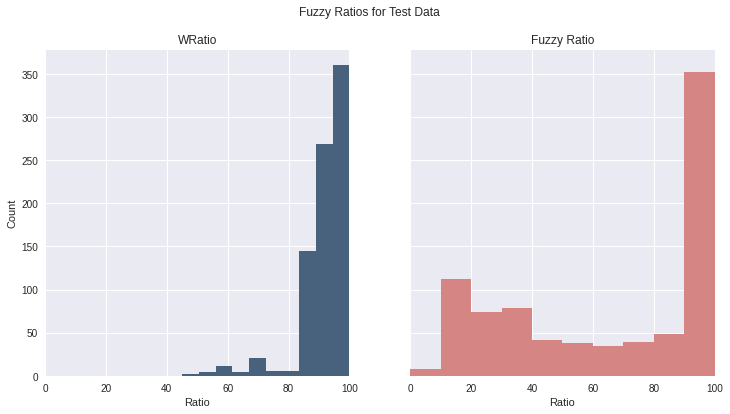

In [61]:
# define subplot axes
fig, (axs) = plt.subplots(nrows=1, ncols=2,figsize=(12, 6), sharey=True)

# set figure title
fig.suptitle('Fuzzy Ratios for Test Data')

# plot histograms
axs[0].hist(fuzzy_df["WRatio"], color ="#48617cff")
axs[1].hist(fuzzy_df["Fuzzy Ratio"], color = "#d68585ff")



# set plot titles
axs[0].set_title('WRatio')
axs[1].set_title('Fuzzy Ratio')


# set labels
plt.setp(axs, xlabel='Ratio')
plt.setp(axs[0], ylabel='Count')
plt.setp(axs, xlim=[0, 100]);

<a id='CL' name="CL"></a>
## [6.Conclusion](#P0)

Even though the WRatio indicates a high accuracy, when looking at the fuzzy ratios we can see for matches below 100% the accuracy drastically decreases.
Looking at some matches, the outputted Business names aren't necessarily fitting.
As a benchmark this model shows us that a more complex approach is required for more accurate results.